# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
from explore import days
import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents an instance of an online advertisement
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [4]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**id**| | *int*|
| **hour** | The date and hour of day |*datetime*|
| **C1** | Anonymized categorical variable |*int*|
|**banner_pos**| Location of ad on the page | *int*|
|**site_id**| Id of the site where the ad was displayed | *str*|
|**site_domain**| | *str*|
|**site_category**| | *str*|
|**app_id**| Square footage of the land where the property is located | *float*|
|**app_domain**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [5]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week,working_hours
366134,2009636145773373157,0,2014-10-27 16:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,16,Monday,True
95054,17172250707259950008,0,2014-10-24 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,2502,0,39,-1,221,6,Friday,False
189299,2922056073063093914,0,2014-10-25 13:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,320,50,1722,0,35,100083,79,13,Saturday,True
569650,4743847194723927815,0,2014-10-29 14:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,320,50,2728,0,290,-1,42,14,Wednesday,True
581283,218700043766238420,1,2014-10-29 17:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1993,2,1063,100084,33,17,Wednesday,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389999 entries, 366134 to 151297
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                389999 non-null  uint64        
 1   click             389999 non-null  int64         
 2   hour              389999 non-null  datetime64[ns]
 3   C1                389999 non-null  int64         
 4   banner_pos        389999 non-null  int64         
 5   site_id           389999 non-null  object        
 6   site_domain       389999 non-null  object        
 7   site_category     389999 non-null  object        
 8   app_id            389999 non-null  object        
 9   app_domain        389999 non-null  object        
 10  app_category      389999 non-null  object        
 11  device_id         389999 non-null  object        
 12  device_ip         389999 non-null  object        
 13  device_model      389999 non-null  object        
 14 

## Explore

### 1. What percentage of visits resulted in a click-through?

<AxesSubplot:xlabel='click', ylabel='count'>

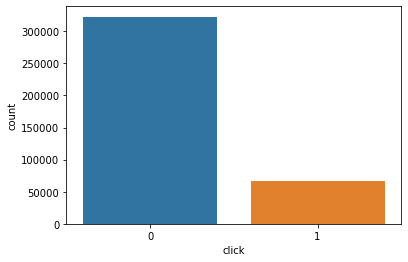

In [7]:
sns.countplot(data=train, x='click')

### 2. Does the hour of the day have an impact of click-throughs?

In [8]:
# plotting defaults
plt.rc('figure', figsize=(20, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

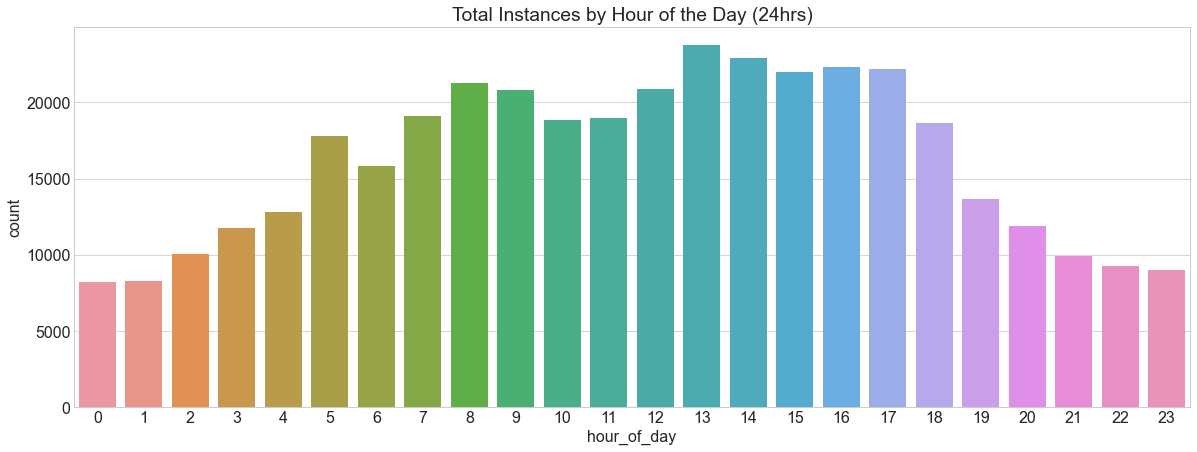

In [9]:
sns.countplot(data=train, x='hour_of_day')
plt.title("Total Instances by Hour of the Day (24hrs)")
plt.show()

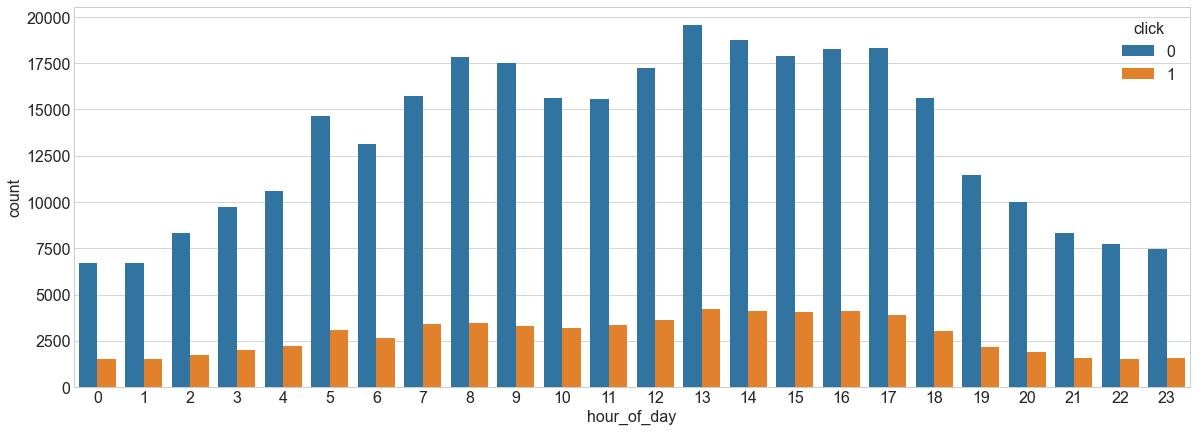

In [10]:
sns.countplot(data=train, x='hour_of_day', hue='click');

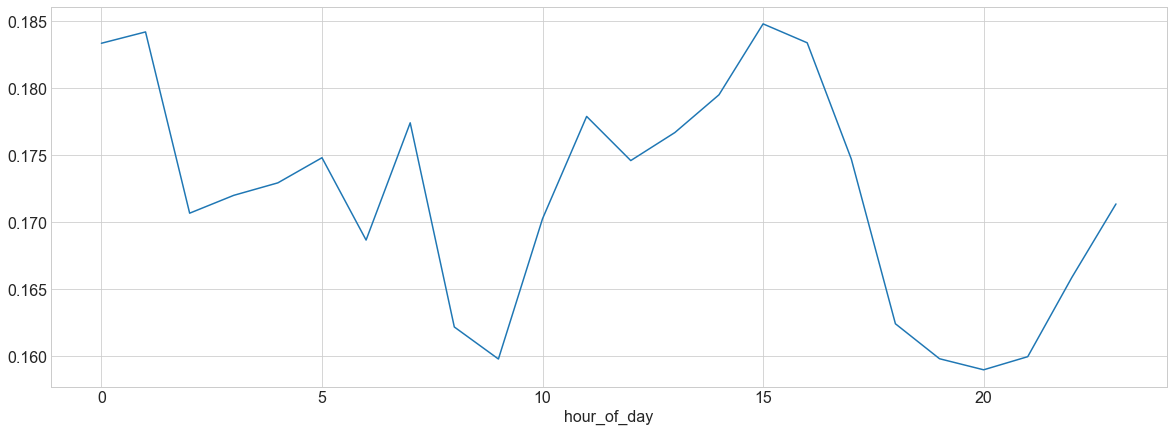

In [11]:
train.groupby('hour_of_day').click.mean().plot();

**It looks like there are more click throughs per instance at 1 am.** 

***Let's do a $chi^2$ to see if there is a relationship***

**Set Hypothesis**

$H_0$ = There is no relationship between ```hour_of_day``` and ```click```.

$H_a$ = There is a relationship between ```hour_of_day``` and ```click```.

In [12]:
#create crosstab of the two variables 
observed = pd.crosstab(train["hour_of_day"], train["click"])

#run χ^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"χ^2: {chi2:.6}\np-value: {p:.6}")

χ^2: 176.366
p-value: 1.28199e-25


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```hour_of_day``` and ```click```.** 

## 3. Does the day of the week have an impact of click-throughs?

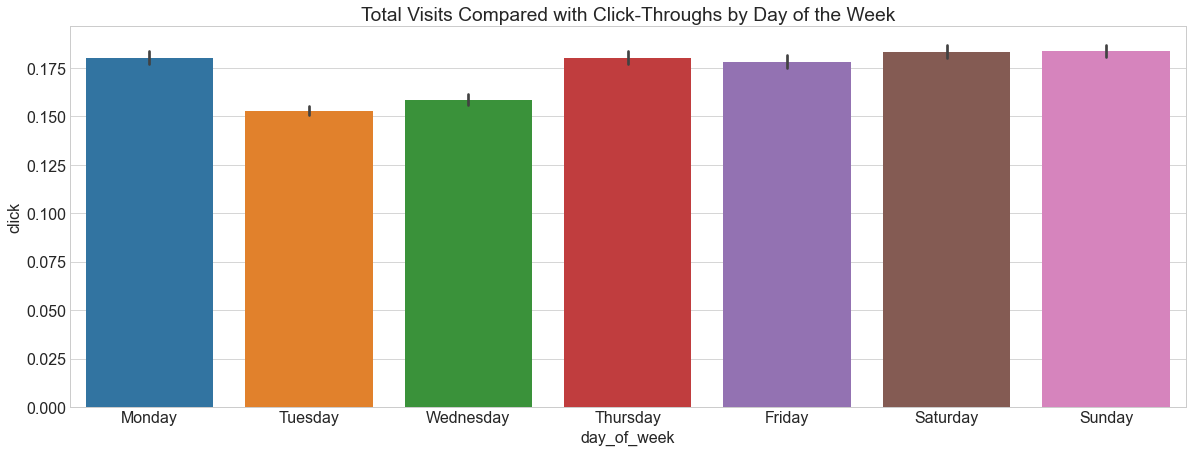

In [13]:
sns.barplot(data=train, x='day_of_week', y='click',order=days)
plt.title("Total Visits Compared with Click-Throughs by Day of the Week")
plt.show()

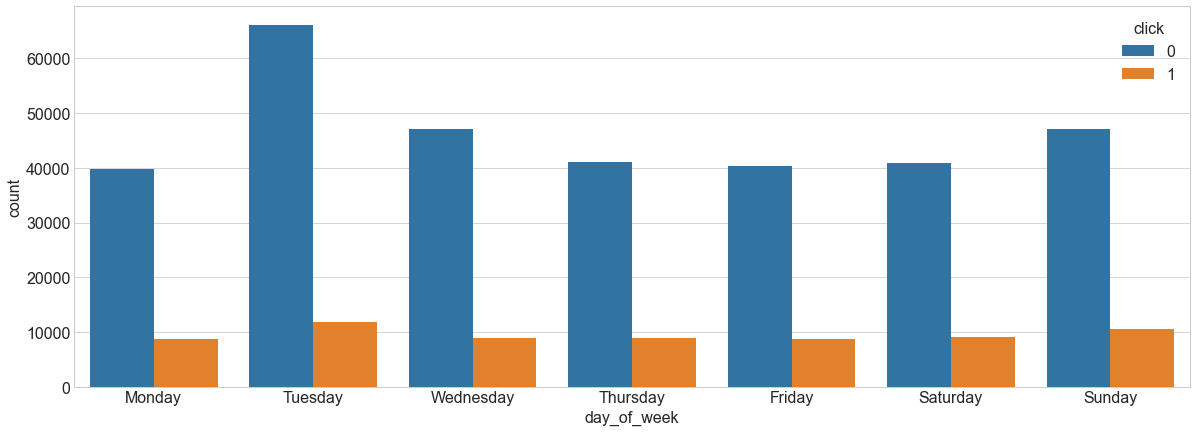

In [14]:
sns.countplot(data=train, x='day_of_week', hue='click', order=days);

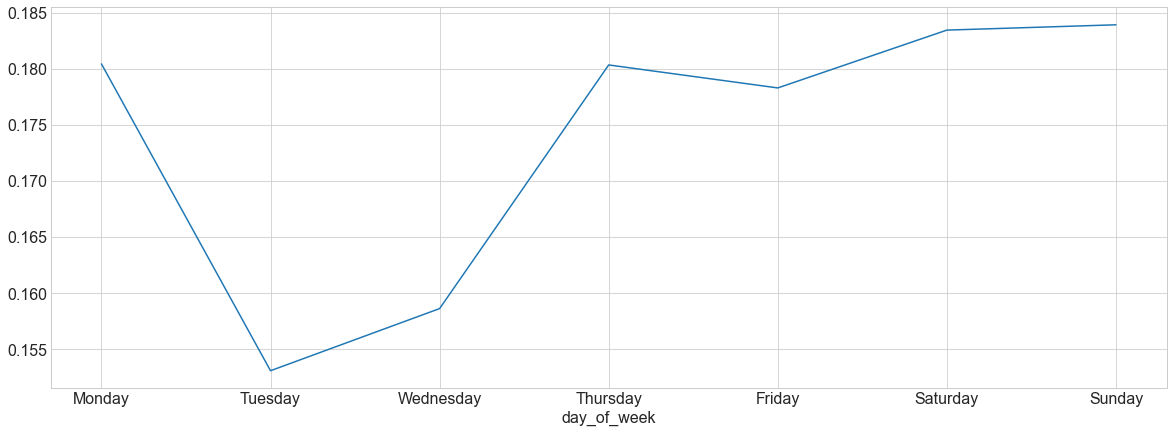

In [15]:
train.groupby('day_of_week').click.mean().reindex(days).plot();

**Set Hypothesis**

$H_0$ = There is no relationship between ```day_of_week``` and ```click```.

$H_a$ = There is a relationship between ```day_of_week``` and ```click```.

In [16]:
#create crosstab of the two variables 
observed = pd.crosstab(train["day_of_week"], train["click"])

#run χ^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"χ^2: {chi2:.6}\np-value: {p:.6}")

χ^2: 431.902
p-value: 3.84995e-90


In [17]:
for day in days:
    observed = pd.crosstab(train["day_of_week"]==day, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f"{day} results: χ^2: {chi2:.6}\np-value: {p:.6}")

Monday results: χ^2: 24.8197
p-value: 6.29506e-07
Tuesday results: χ^2: 256.61
p-value: 9.40733e-58
Wednesday results: χ^2: 87.5769
p-value: 8.1065e-21
Thursday results: χ^2: 25.0873
p-value: 5.47915e-07
Friday results: χ^2: 13.4598
p-value: 0.000243728
Saturday results: χ^2: 48.8018
p-value: 2.83173e-12
Sunday results: χ^2: 62.5405
p-value: 2.61018e-15


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```day_of_week``` and ```click```.** 

## 4. Does banner position impact click through?

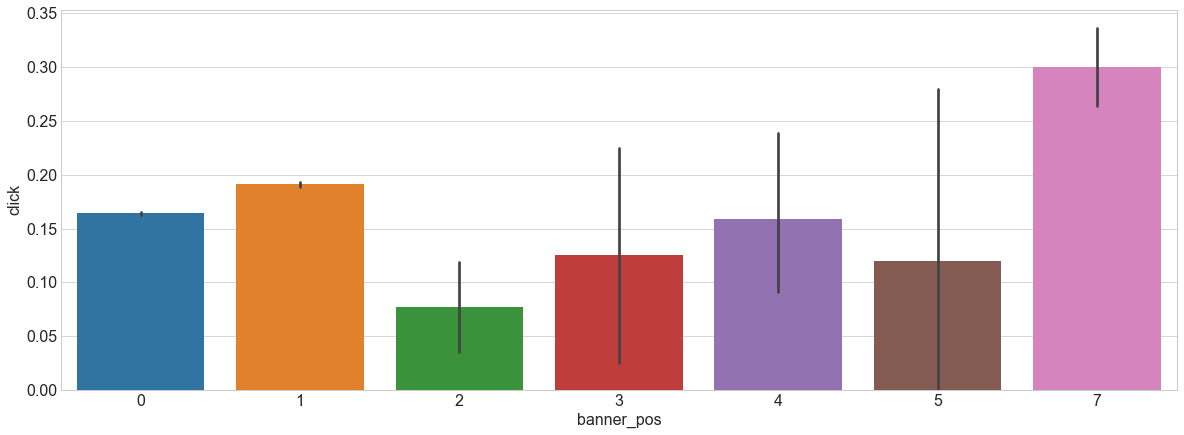

In [18]:
sns.barplot(data=train, x='banner_pos', y='click');

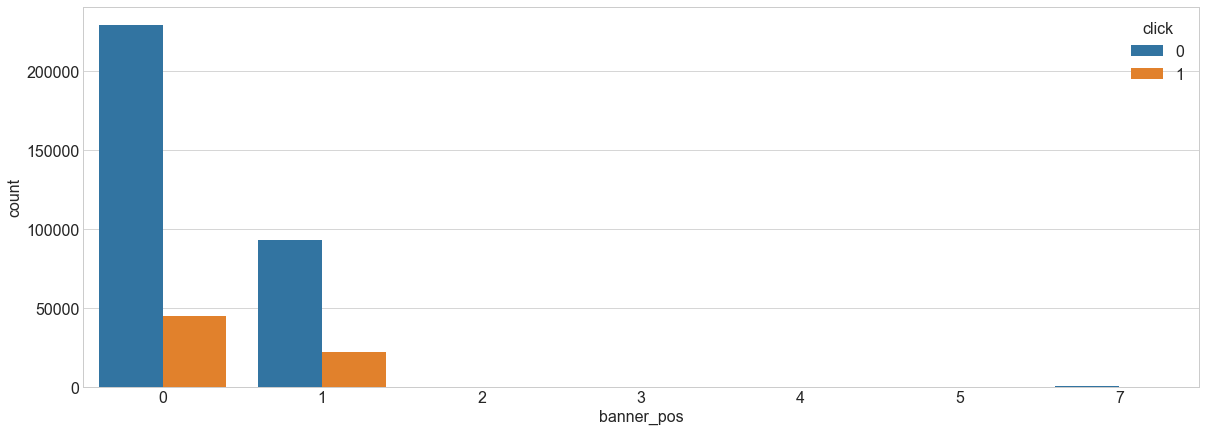

In [19]:
sns.countplot(data=train, x='banner_pos', hue='click');

**Set Hypothesis**

$H_0$ = There is no association between ```banner_pos``` and ```click```.

$H_a$ = There is a association between ```banner_pos``` and ```click```.

In [20]:
for i in train['banner_pos'].unique():
    observed = pd.crosstab(train["banner_pos"]==i, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f"banner_pos {i} results: χ^2: {chi2:.6}\np-value: {p:.6}")

banner_pos 0 results: χ^2: 419.231
p-value: 3.58723e-93
banner_pos 1 results: χ^2: 397.382
p-value: 2.04537e-88
banner_pos 7 results: χ^2: 72.1174
p-value: 2.02772e-17
banner_pos 4 results: χ^2: 0.0361544
p-value: 0.849197
banner_pos 3 results: χ^2: 0.342021
p-value: 0.558665
banner_pos 2 results: χ^2: 8.48676
p-value: 0.00357741
banner_pos 5 results: χ^2: 0.184251
p-value: 0.667745


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```banner_pos``` and ```click```.** 

## 5. Does

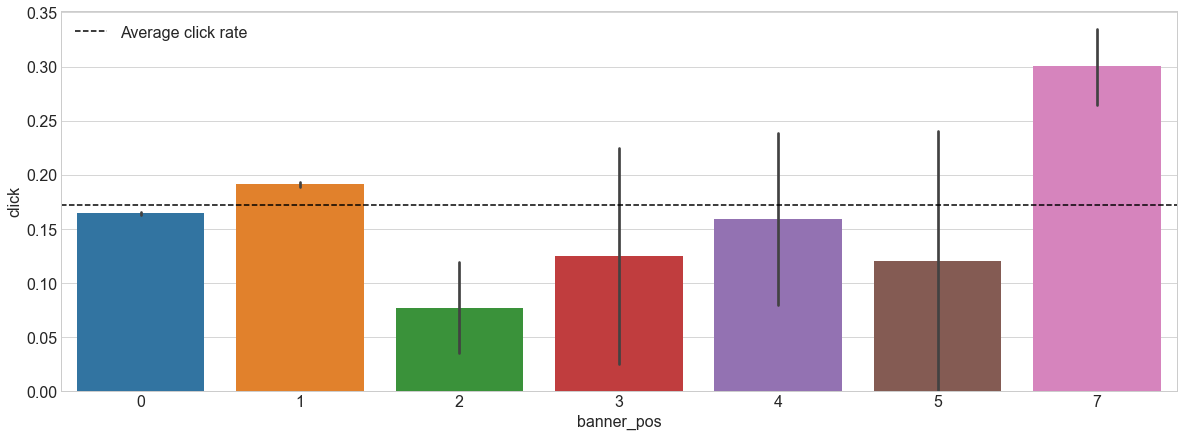

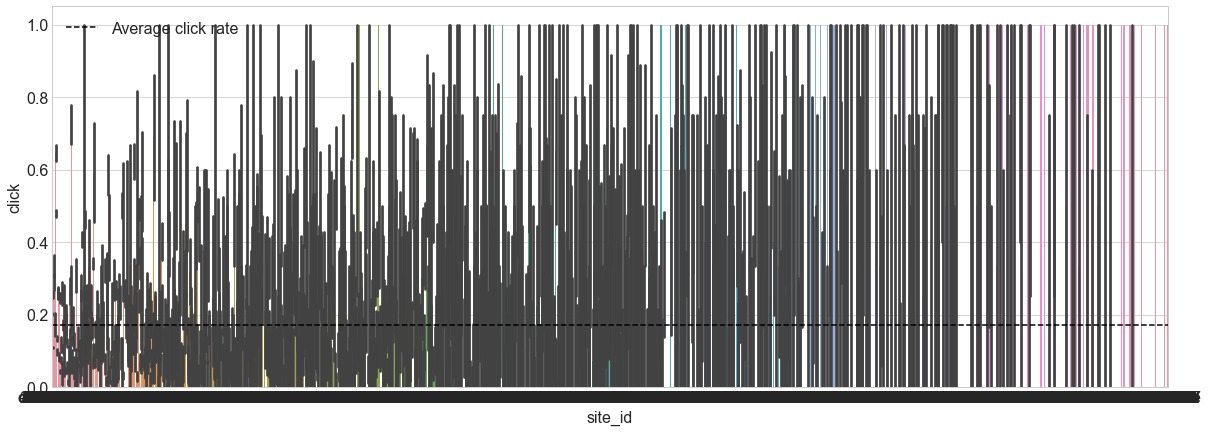

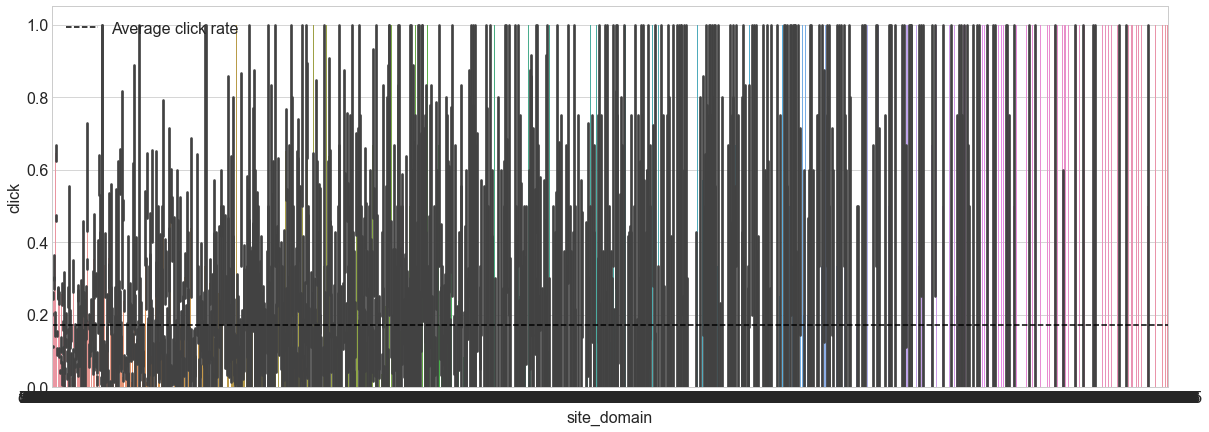

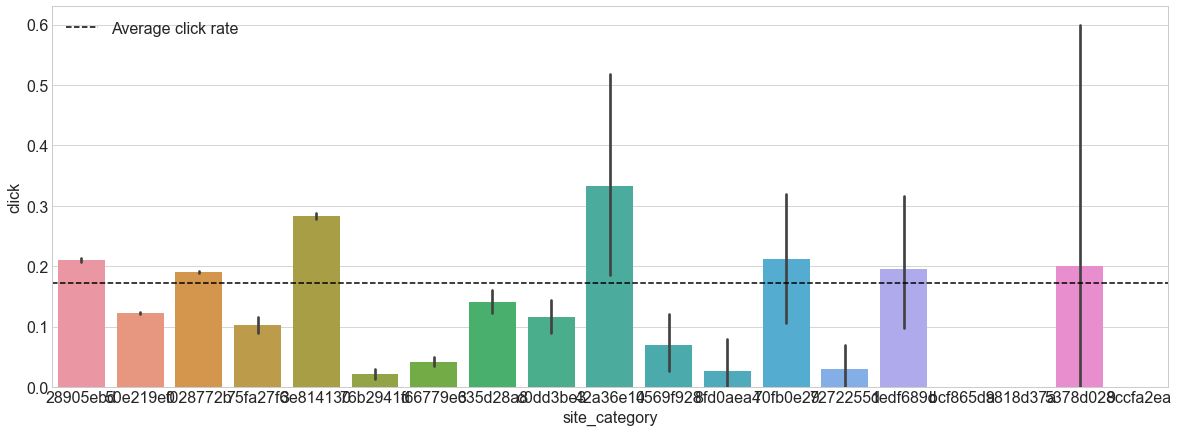

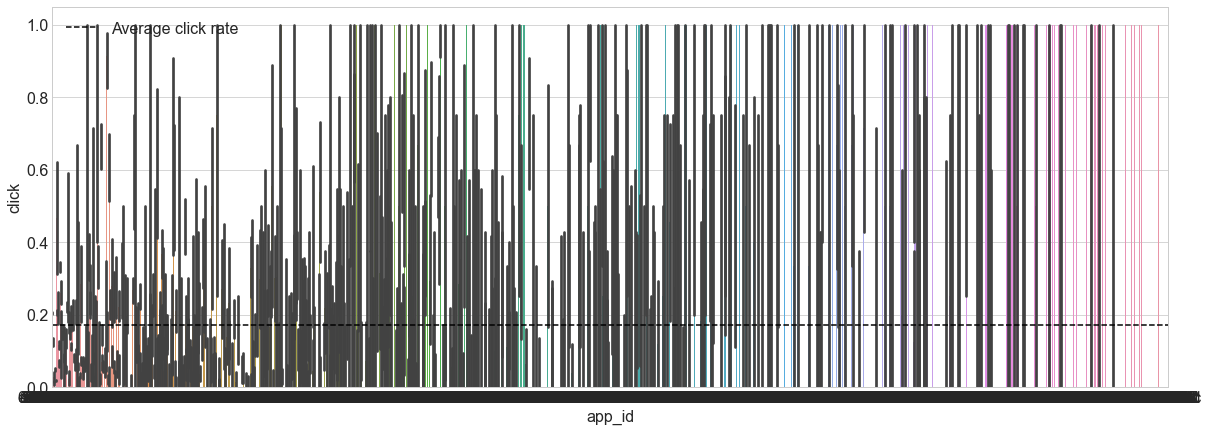

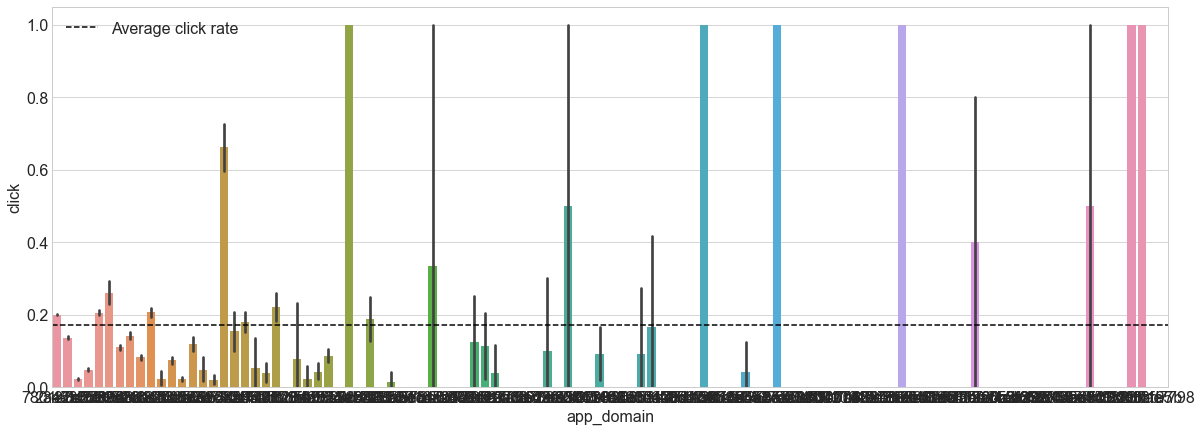

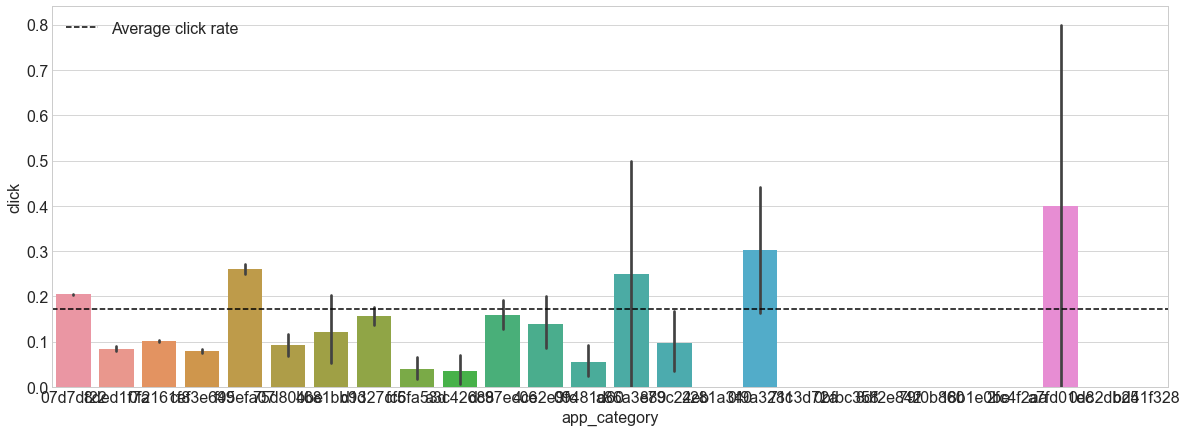

KeyboardInterrupt: 

In [82]:
cat_vars = list(train.select_dtypes(exclude=np.number).columns)
cat_vars.remove('hour')
for col in cat_vars:
        sns.barplot(x=col, y='click', data=train)
        rate = train['click'].mean()
        plt.axhline(rate, label = f'Average click rate', linestyle='--', color='black')
        plt.legend()
        plt.show()

In [93]:
pd.options.display.float_format = '{:,.6f}'.format

In [94]:
metric = []

for i in train['site_category'].unique():
    observed = pd.crosstab(train["site_category"]==i, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    output = {
        "site_category": i,
        "χ^2": chi2,
        "p-value": p
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df.sort_values(by=['p-value','χ^2'], ascending=[True,False])

,site_category,χ^2,p-value
1,50e219e0,"4,465.993168",0.000000
4,3e814130,"2,981.872118",0.000000
0,28905ebd,852.645160,0.000000
2,f028772b,420.698714,0.000000
6,f66779e6,288.722018,0.000000
5,76b2941d,157.779375,0.000000
3,75fa27f6,66.040409,0.000000
13,72722551,13.238874,0.000274
8,c0dd3be3,10.431386,0.001239
7,335d28a8,8.441144,0.003668


In [95]:
metric = []

for i in train['app_category'].unique():
    observed = pd.crosstab(train["app_category"]==i, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    output = {
        "app_category": i,
        "χ^2": chi2,
        "p-value": p
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df.sort_values(by=['p-value','χ^2'], ascending=[True,False])

,app_category,χ^2,p-value
0,07d7df22,"5,831.851146",0.000000
2,0f2161f8,"4,129.545993",0.000000
3,cef3e649,980.671710,0.000000
1,8ded1f7a,739.181191,0.000000
4,f95efa07,411.283581,0.000000
8,fc6fa53d,32.114246,0.000000
5,75d80bbe,20.890972,0.000005
9,a3c42688,17.398241,0.000030
12,09481d60,14.889462,0.000114
15,2281a340,4.894717,0.026939


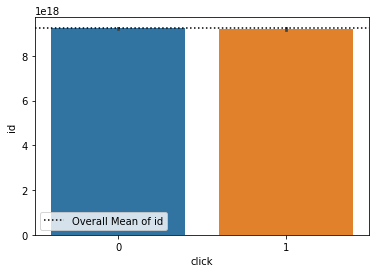

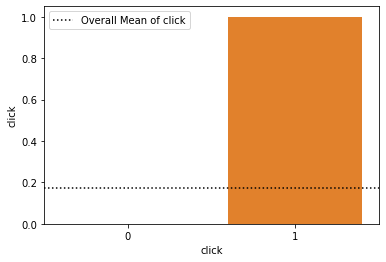

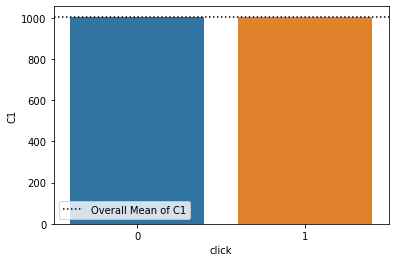

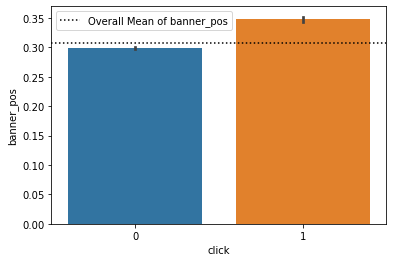

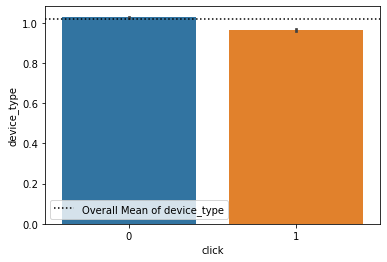

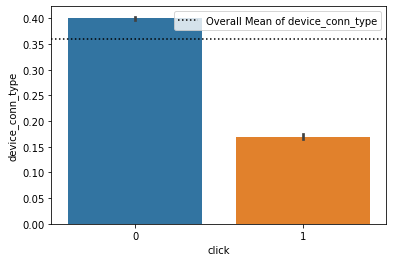

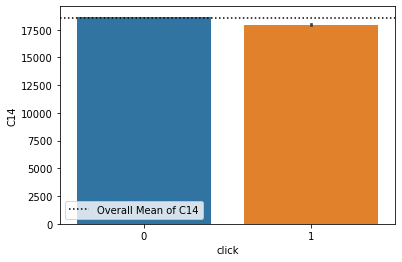

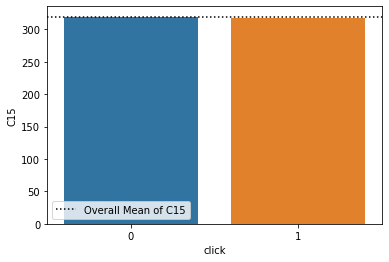

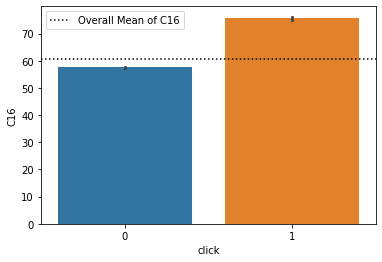

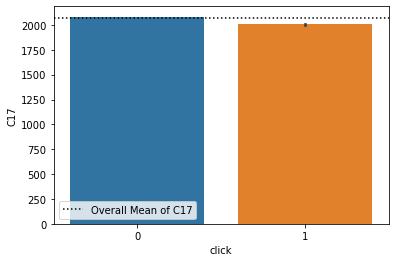

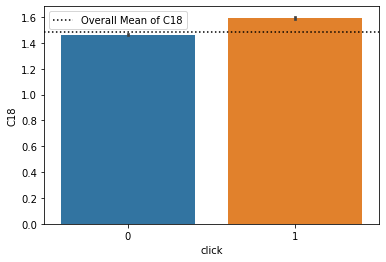

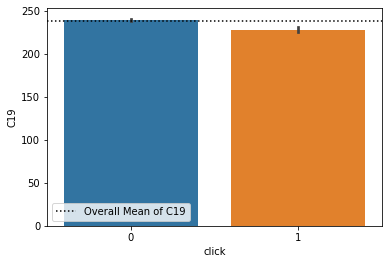

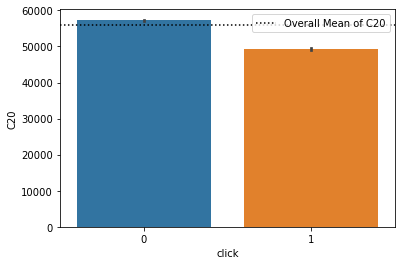

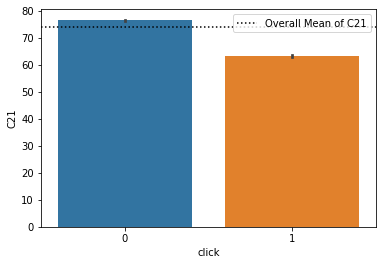

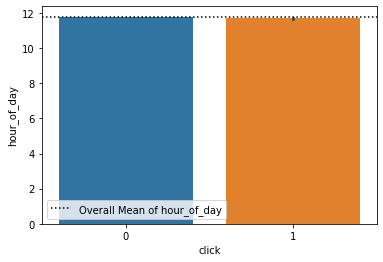

In [7]:
cont_vars = list(train.select_dtypes(include=np.number).columns)
for col in cont_vars:
        sns.barplot(x='click', y=col, data=train)
        rate = train[col].mean()
        plt.axhline(rate,  label = f'Overall Mean of {col}', linestyle='dotted', color='black')
        plt.legend()
        plt.show()

In [8]:
train.device_conn_type.value_counts()

0    333683
2     29437
3     26413
5       466
Name: device_conn_type, dtype: int64

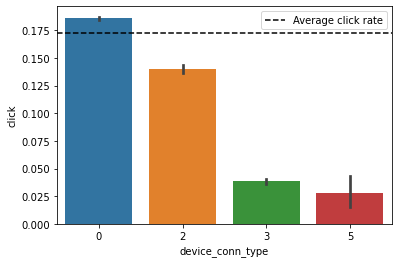

In [10]:
sns.barplot(x='device_conn_type', y='click', data=train)
rate = train['click'].mean()
plt.axhline(rate, label = f'Average click rate', linestyle='--', color='black')
plt.legend()
plt.show()

In [12]:
metric = []

for i in train['device_conn_type'].unique():
    observed = pd.crosstab(train["device_conn_type"]==i, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    output = {
        "device_conn_type": i,
        "χ^2": chi2,
        "p-value": p
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df.sort_values(by=['p-value','χ^2'], ascending=[True,False])

,device_conn_type,χ^2,p-value
1,3,3552.025452,0.000000e+00
0,0,3009.629469,0.000000e+00
2,2,231.552896,2.733296e-52
3,5,67.288990,2.344873e-16


### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**size_location_cluster**| |
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [14]:
cols_to_encode = ['banner_pos', 'hour_of_day', 'day_of_week', 'site_category', 'app_category', 'device_conn_type']

In [15]:
train, validate, test = m.get_dumdum(train, validate, test, cols_to_encode)

In [37]:
drivers = ['day_of_week_Tuesday', 'day_of_week_Wednesday', 
           'app_category_07d7df22', 'site_category_50e219e0',
          'device_conn_type_0', 'C16', 'C17', 'C18', 'C19','C20']

In [38]:
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'click', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [50]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 82.76%


### Model Comparison

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [39]:
########### DECICSION TREE HYPERPARAMETER TESTING####################

# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metric = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df["difference"] = df.train_accuracy - df.validate_accuracy

In [40]:
df.sort_values(by=['difference' ,'train_accuracy'])

,max_depth,train_accuracy,validate_accuracy,difference
3,4,0.828438,0.828489,-0.000051
4,5,0.829046,0.829089,-0.000043
0,1,0.827571,0.827567,0.000005
1,2,0.827571,0.827567,0.000005
2,3,0.827571,0.827567,0.000005
5,6,0.829464,0.829211,0.000253
6,7,0.829469,0.829178,0.000291
7,8,0.829838,0.829300,0.000538
8,9,0.830761,0.829878,0.000883
9,10,0.831118,0.829800,0.001318


In [41]:
m.random_forest_results(X_train, y_train, X_validate, y_validate)

Random Forest
Train Accuracy: 82.76%
Validate Accuracy: 82.76%
Difference: 0.00%


In [42]:
m.log_results(X_train, y_train, X_validate, y_validate)

Logistic Regression
Train Accuracy: 82.74%
Validate Accuracy: 82.74%
Difference: 0.00%


### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [29]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 